# **Experimentación de la Redes Siamesas y modelo FaceNet con la base datos "Georgia Tech"**

### Importando librerias

In [2]:
import sys
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng
from tqdm.notebook import tqdm

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split

## 1. Implementacion del modelo

### 1.1 Funciones para inicializar parametros

Segun el [artículo](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf) sugiere las siguientes inicializaciones para las capas CNN:
 - Pesos con una media de 0.0 y una desviación estándar de 0.01
 - Bias con una media de 0.5 y una desviación estándar de 0.01

In [7]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [8]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

### 1.2 Modelo Red Siamesa con FaceNet

In [9]:
from keras.models import load_model

##### 1.2.1 Triplet loss function de Facenet

In [10]:
def triplet_loss(y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[1])) )
    neg_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[2])) )
    basic_loss = pos_dist - neg_dist + alpha
    
    loss = tf.maximum(basic_loss, 0.0)
   
    return loss

##### 1.2.2 Cargar el modelo Facenet
El modelo FaceNet se debe descargar en el siguiente enlace y guardarlo dentro de la carpeta "models": [FaceNet](https://drive.google.com/file/d/1wsJs5ZnhI7meqdOX6S9Indm9l1zmsisH/view?usp=sharing)

In [11]:
FRmodel = load_model('models/facenet_keras.h5', custom_objects={'triplet_loss': triplet_loss})

In [12]:
def get_siamese_model(input_shape):
    # Se define la dimensión de los tensores para las dos entradas de imágenes
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Red Neuronal Convolucional
    model = Sequential()
    model.add(FRmodel)
    
    
    # Generar los vectores caracteristicos para las dos imágenes
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Agregar la capa personalizada para calcular la diferencia absoluta entre los vectores caracteristicos de las dos imágenes
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Agregar la capa densa el cuál generará el puntaje de similitud
    # Por medio de la función de activación sigmoid nos indicará con 0 si las dos imágenes son diferentes y 1 si son similares
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Conectar las entradas con la salida
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # Retornar el modelo
    return siamese_net

#### 1.2.1. Resumen del modelo

In [13]:
model = get_siamese_model((160, 160, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          22808144    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           sequential[1][0]             

#### 1.2.2. Compilación del modelo

In [14]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["acc"])

## 2. Importar data 

Se escogio el dataset de Georgia Tech debido a que brinda una gran cantidad de imagenes a colores y porque la posicion de los rostros varian considerablemente, lo que haria al modelo mas robusto. Este dataset contiene 750 imagenes en formato .jpg, pertenecientes a 50 personas. Se decidio agrupar las imagenes en 50 carpetas con 15 imagenes cada una. Ademas,se cambiaron las etiquetas dentro de cada carpeta a un numero entre 1 a 15. 

A partir de esta distribucion, se realizo un pequeño programa para escoger de manera aleatoria parejas iguales(imagenes dentro de la misma carpeta) y parejas sin similitud(imagenes en diferentes carpetas). Se escogieron 10000 parejas iguales y 10000 parejas sin similitud para mantener una correcta distribucion. Esta informacion se guardo como direciones de la imagen dentro de un DataFrame. Si las parejas sin similares el campo "Igualdad" es 1 y si son diferentes es 0. 

In [25]:
Data=pd.read_csv("Imagenes_siamesas.csv")

In [26]:
Data.head()

,Imagen1,Imagen2,Igualdad
0,s1/5.jpg,s1/6.jpg,1.0
1,s1/7.jpg,s1/2.jpg,1.0
2,s1/9.jpg,s1/10.jpg,1.0
3,s1/3.jpg,s1/5.jpg,1.0
4,s1/3.jpg,s1/10.jpg,1.0


In [27]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Imagen1   20000 non-null  object 
 1   Imagen2   20000 non-null  object 
 2   Igualdad  20000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 468.9+ KB


### 2.1 Transformando a entero la variable de igualdad

In [28]:
Data["Igualdad"]=Data["Igualdad"].astype(int)

### 2.2 Separando en train y validation set

Lo ideal es tener un train y test set que tengan una distribucion similar, por lo que se realizara una separacion estratificada con respecto a la columna "Igualdad"

In [29]:
df_train,df_val=train_test_split(Data,test_size=0.15,stratify=Data["Igualdad"])

In [30]:
df_val=df_val.reset_index(drop=True)

## 3. Funciones de entrenamiento

In [5]:
images_path="data_georgia/cropped_faces/"

### 3.1 Creando ImageDataGenerators para el entrenamiento

Utilizando la funcion de ImageDataGenerator, creare dos nuevos generadores de imagenes que brinden dos imagenes de entrada al modelo segun la informacion brindada en el Dataframe que pasa a la funcion. 

Para los datos de entrada se realiza un poco de data augmentation al agregarle un angulo de rotacion de 5° y haciendo un maximo zoom de 10%. Esto no aplica para las imagenes de validacion.

Información importante:
- batch_size: 32
- tamaño de la imagen: 160x160x3
- rotation_range=5
- zoom_range=0.1

In [19]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   zoom_range=0.1)
test_generator=ImageDataGenerator(rescale=1./255)
val_generator=ImageDataGenerator(rescale=1./255)


In [20]:
def gen_train_flow_for_two_inputs(X1, X2, y):
    genX1 =train_generator.flow_from_dataframe(dataframe=df_train,
                                                 directory=images_path,
                                                 x_col=X1,
                                                 y_col=y,
                                                  target_size=(160,160),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    genX2 = train_generator.flow_from_dataframe(dataframe=df_train,
                                                 directory=images_path,
                                                 x_col=X2,
                                                 y_col=y,
                                                  target_size=(160,160),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]


In [21]:
def gen_val_flow_for_two_inputs(X1, X2, y):
    genX1 =val_generator.flow_from_dataframe(dataframe=df_val,
                                                 directory=images_path,
                                                 x_col=X1,
                                                 y_col=y,
                                                  target_size=(160,160),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    genX2 = val_generator.flow_from_dataframe(dataframe=df_val,
                                                 directory=images_path,
                                                 x_col=X2,
                                                 y_col=y,
                                                  target_size=(160,160),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [22]:
gen_train_flow = gen_train_flow_for_two_inputs("Imagen1", "Imagen2", "Igualdad")

In [23]:
gen_val_flow = gen_val_flow_for_two_inputs("Imagen1", "Imagen2", "Igualdad")

## 4. Entrenamiento Modelo
Para descargar el modelo entrenado ingresar a este enlace: [RS_georgia_db.h5](https://drive.google.com/file/d/1leTDVAZKUgVgrrnplric7jT10q8hKU_5/view?usp=sharing)

In [41]:
mc = ModelCheckpoint('RS_facenet_georgia_db.h5', monitor='val_loss', mode='min', save_best_only=True)
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=7, verbose=1, mode='auto', cooldown=5, min_lr=0.0001)
callbacks = [mc, red_lr_plat]
logs = model.fit_generator(gen_train_flow,
                            steps_per_epoch = 400, 
                            validation_data = gen_val_flow,
                            validation_steps = 80,
                            epochs = 10,
                            callbacks= callbacks)

Epoch 1/10
400/400 [==============================] - 1807s 5s/step - loss: 0.0826 - acc: 0.9938 - val_loss: 0.0337 - val_acc: 0.9984 - lr: 6.0000e-05
Epoch 2/10
400/400 [==============================] - 1762s 4s/step - loss: 0.0398 - acc: 0.9982 - val_loss: 0.0181 - val_acc: 1.0000 - lr: 6.0000e-05
Epoch 3/10
400/400 [==============================] - 1831s 5s/step - loss: 0.0223 - acc: 0.9998 - val_loss: 0.0104 - val_acc: 0.9992 - lr: 6.0000e-05
Epoch 4/10
400/400 [==============================] - 1726s 4s/step - loss: 0.0159 - acc: 0.9998 - val_loss: 0.0078 - val_acc: 1.0000 - lr: 6.0000e-05
Epoch 5/10
400/400 [==============================] - 1699s 4s/step - loss: 0.0115 - acc: 0.9999 - val_loss: 0.0054 - val_acc: 1.0000 - lr: 6.0000e-05
Epoch 6/10
400/400 [==============================] - 1668s 4s/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000 - lr: 6.0000e-05
Epoch 7/10
400/400 [==============================] - 1663s 4s/step - loss: 0.0063 - acc: 1.00

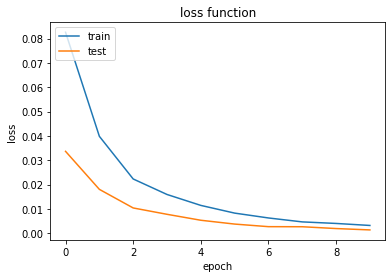

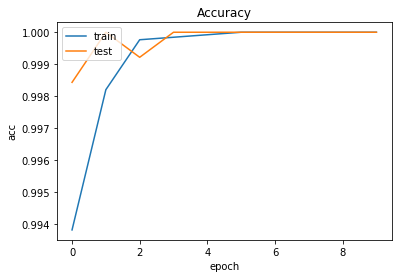

In [44]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])
plt.title('loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(logs.history['acc'])
plt.plot(logs.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.1 Adquirir los mejores parametros del modelo entrenado

Para descargar el modelo ingresar a este enlace: [RS_facenet_georgia](https://drive.google.com/file/d/1BKt28nck-Q4wBQ9PWd6T3h5xmzYQc8ZR/view?usp=sharing)

In [15]:
model.load_weights('RS_facenet_georgia_db.h5')# Cargar los mejores pesos

## 5. Generar predicción

Para este proyecto el test set serian las imagenes que vienen de la camara. Sin embargo, para probar la funcion se aplicara al validation set.

### 5.1 Creando generador de imagenes para el test set

In [16]:
def gen_test_flow_for_two_inputs(X1, X2, y,df,dire):
    genX1 =test_generator.flow_from_dataframe(dataframe=df,
                                                 directory=dire,
                                                 x_col=X1,
                                                 y_col=y,
                                                  target_size=(160,160),
                                                  batch_size=1,
                                                  class_mode="raw",
                                                  shuffle=False)
    genX2 = test_generator.flow_from_dataframe(dataframe=df,
                                                 directory=dire,
                                                 x_col=X2,
                                                 y_col=y,
                                                  target_size=(160,160),
                                                  batch_size=1,
                                                  class_mode="raw",
                                                  shuffle=False)
    while True:
                X1i = genX1.next()
                X2i = genX2.next()
                yield [X1i[0], X2i[0]]

In [17]:
def get_prediction(df,direccion_prediccion):
    predictions=model.predict_generator(gen_test_flow_for_two_inputs("Imagen1", "Imagen2", "Imagen2",
                                                                            df,direccion_prediccion), steps = 1)
    return predictions

### 5.2 Generando las predicciones por cada row del DataFrame

In [31]:
lista_predicciones=[]

for i in tqdm(range(len(df_val))):

    df_minitest=pd.DataFrame({"Imagen1":[df_val.loc[i,'Imagen1']],"Imagen2":[df_val.loc[i,'Imagen2']]})
    tensor = get_prediction(df_minitest,images_path)
    tensor=tensor.ravel()[0]

    lista_predicciones.append(tensor)

Instructions for updating:
Please use Model.predict, which supports generators.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 va

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

In [32]:
print(lista_predicciones[:5])

[8.30958e-05, 0.99999964, 0.99975437, 0.99994504, 0.9997873]


In [33]:
lista_final=np.array(lista_predicciones)

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
mean_absolute_error(lista_final, list(df_val["Igualdad"]))

0.0008507758837810684

### 5.3 Generando N way 

In [37]:
def predecir_n_way(n,nr_examples):
    lista_precision=[]
    cont=0
    random_2=0
    random2=0
    for i in tqdm(range(nr_examples)):
        lista_imagenes=[]
        lista_predicciones=[]

        random1=np.random.randint(49)
        random_1=np.random.randint(14)+1
        random_2=np.random.randint(14)+1
        unica_igualdad="s{}/{}.jpg".format(random1+1,random_1)

        while(random_2==random_1):
                random_2=np.random.randint(14)+1

        lista_imagenes.append("s{}/{}.jpg".format(random1+1,random_2))

        for k in range(n-1):
            random2=np.random.randint(49)
            while(random2==random1):
                random2=np.random.randint(49)
            lista_imagenes.append("s{}/{}.jpg".format(random2+1,np.random.randint(14)+1))


        df_n_way=pd.DataFrame({"Imagen1":unica_igualdad,"Imagen2":lista_imagenes,"Igualdad":[1]+[0]*(n-1)})

        for j in range(len(df_n_way)):

            df_minitest=pd.DataFrame({"Imagen1":[df_n_way.loc[j,'Imagen1']],"Imagen2":[df_n_way.loc[j,'Imagen2']]})
            tensor = get_prediction(df_minitest,images_path)
            tensor=tensor.ravel()[0]
            lista_predicciones.append(tensor) 
        argumento=np.argmax(lista_predicciones)
        if argumento ==0:
            lista_precision.append(1)
        else:
            lista_precision.append(0)
    
        print(i)
    print(np.sum(lista_precision)/len(lista_precision))
    return np.sum(lista_precision)/len(lista_precision)


In [38]:
Siamesa_20_way=predecir_n_way(20,1000)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
5
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
11
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
17
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
23
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
29
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
35
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
52
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
58
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
64
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
70
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
76
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
82
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
88
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

111
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
117
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
123
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
129
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
135
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
141
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
147
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
153
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
182
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
188
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
194
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
200
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
206
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
212
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
218
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
224
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

235
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
241
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
247
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
253
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
259
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
265
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
271
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
277
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
283
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
289
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
295
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

306
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
312
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
318
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
324
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
330
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
336
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
342
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
359
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
365
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
371
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
377
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
383
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

400
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
406
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
412
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
418
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
424
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
430
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

453
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
459
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
465
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
471
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
477
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
483
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
489
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
495
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
518
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
524
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
530
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
536
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
542
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
548
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
565
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
571
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
577
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
583
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
589
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
606
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
612
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
618
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
630
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
647
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
653
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
659
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
665
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
671
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
688
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
694
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
700
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
706
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
712
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
729
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
735
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
741
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
747
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
753
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
759
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

776
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
782
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
788
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
794
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
800
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
806
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
812
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

823
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
829
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
835
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
841
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
847
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
853
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

864
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
870
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
876
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
882
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
888
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
894
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
900
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
906
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
923
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
929
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
935
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
941
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
947
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
953
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

970
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
976
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
982
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
988
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
994
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

In [39]:
Siamesa_10_way=predecir_n_way(10,1000)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
0
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
11
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
12
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
23
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
35
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
46
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
47
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
58
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
59
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
70
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

81
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
82
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
93
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
94
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
105
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
117
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
128
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
129
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
140
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
152
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

163
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
164
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
175
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
176
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
187
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
199
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

210
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
211
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
222
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
223
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
234
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
246
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
258
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

269
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
270
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
281
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
282
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
293
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
294
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
305
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

316
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
317
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
328
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
329
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
340
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
352
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

363
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
364
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
375
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
376
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
387
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
399
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
410
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
411
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
422
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
434
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
446
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
457
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
458
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
469
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
481
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
493
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

504
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
505
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
516
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
517
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
528
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
540
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
551
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
552
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
563
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
564
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
575
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
587
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

598
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
599
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
610
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
611
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
622
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
623
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
634
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

645
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
646
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
657
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
658
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
669
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
681
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
692
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
693
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
704
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
705
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
716
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
728
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
740
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
751
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
752
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
763
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
775
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
786
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
787
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
798
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
799
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
810
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
822
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
833
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
834
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
845
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
846
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
857
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
869
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
880
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
881
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
892
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
904
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
915
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
916
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
927
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
928
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
939
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
951
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

962
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
963
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
974
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
975
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
986
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
987
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
998
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

In [40]:
Siamesa_4_way=predecir_n_way(4,1000)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
0
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
1
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
2
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 valida

28
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
29
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
30
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
31
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
58
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
59
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
60
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 val

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
87
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
88
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
89
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 val

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
117
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
118
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
119
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

145
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
146
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
147
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
148
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
175
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
176
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
177
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

203
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
204
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
205
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
206
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

232
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
233
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
234
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
235
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
262
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
263
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
264
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
265
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
291
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
292
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
293
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
294
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

320
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
321
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
322
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
323
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
350
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
351
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
352
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
379
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
380
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
381
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
382
Foun

408
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
409
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
410
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
411
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
438
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
439
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
440
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
467
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
468
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
469
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
470
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
496
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
497
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
498
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
499
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

525
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
526
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
527
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
528
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
555
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
556
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
557
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
584
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
585
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
586
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
587
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
613
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
614
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
615
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
616
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
642
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
643
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
644
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
645
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

671
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
672
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
673
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
674
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
701
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
702
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
703
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
730
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
731
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
732
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
733
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
759
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
760
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
761
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
762
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

788
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
789
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
790
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
791
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
818
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
819
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
820
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
847
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
848
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
849
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
876
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
877
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
878
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
905
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
906
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
907
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
908
Foun

934
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
935
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
936
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
937
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
964
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
965
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
966
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
993
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
994
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
995
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
996
Foun

In [41]:
Siamesa_20_way,Siamesa_10_way,Siamesa_4_way

(0.963, 0.987, 0.992)

In [42]:
Siamesa_resultados=pd.DataFrame({"N Way":["20 way","10 way","4 way"],"Precision":[Siamesa_20_way,Siamesa_10_way,Siamesa_4_way]})

In [43]:
Siamesa_resultados

,N Way,Precision
0,20 way,0.963
1,10 way,0.987
2,4 way,0.992


In [44]:
Siamesa_resultados.to_csv("Facenet_resultados_nway.csv",index=False)